In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = f17e0b2
conc = na
dv = 0.01
klin = 0
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

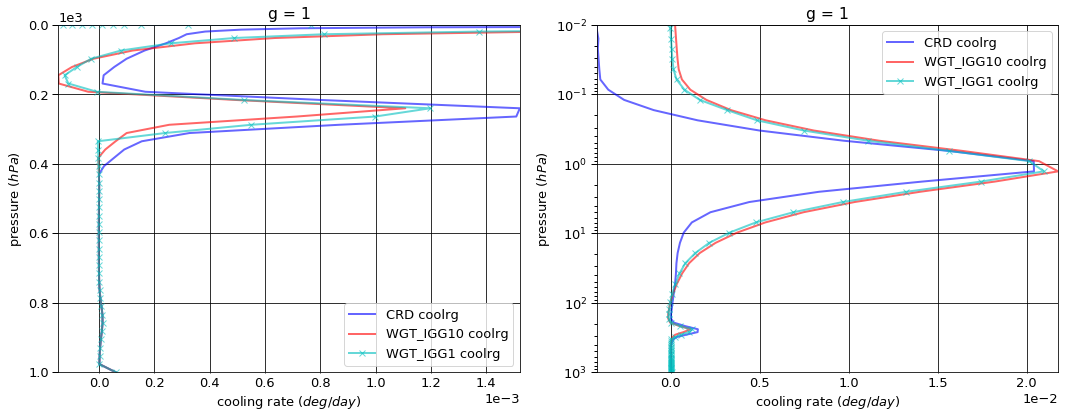

# Figure: cooling rate g-group 2

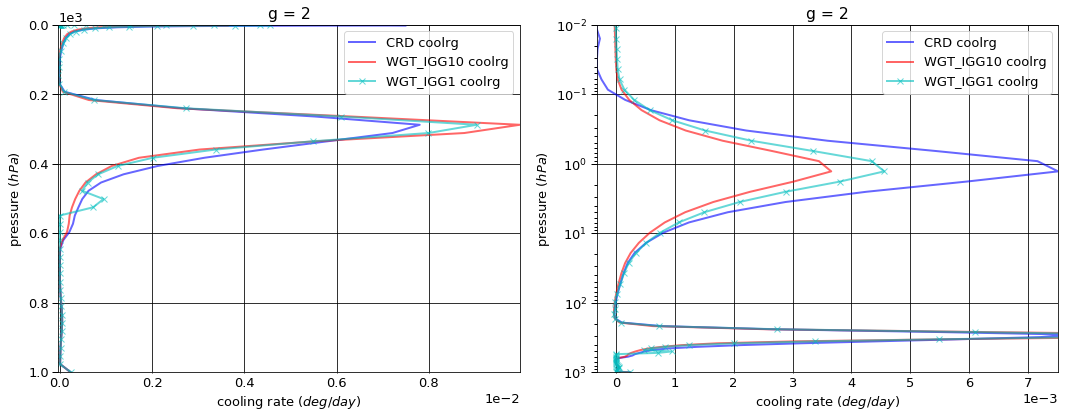

# Figure: cooling rate g-group 3

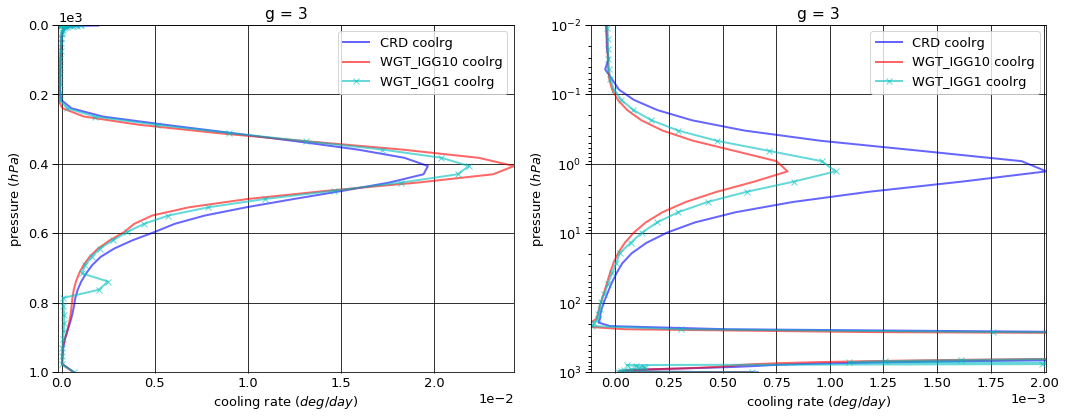

# Figure: cooling rate g-group 4

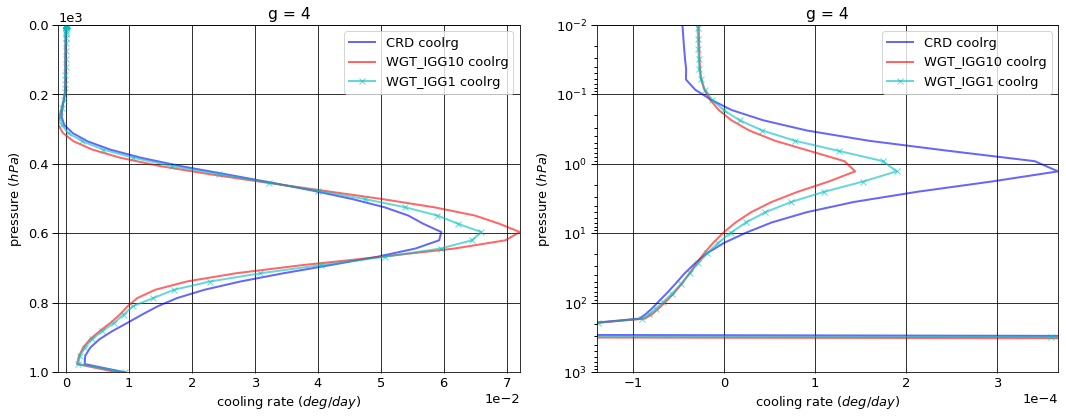

# Figure: cooling rate g-group 5

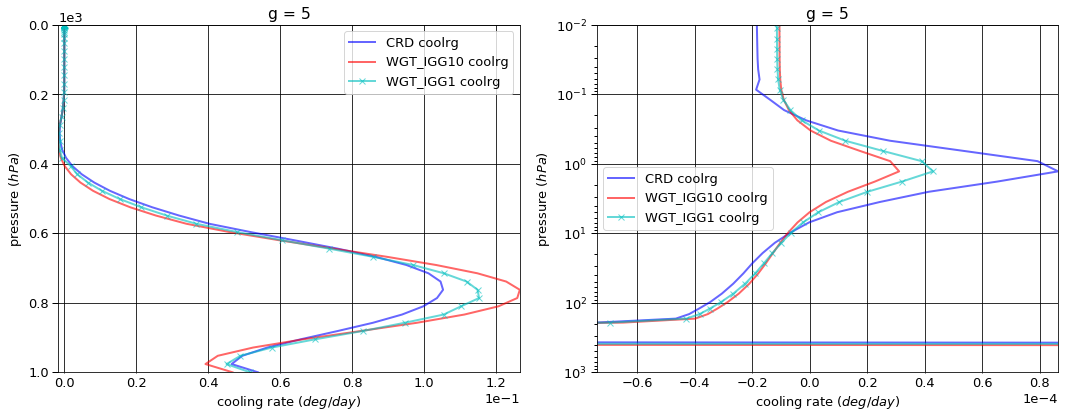

# Figure: cooling rate g-group 6

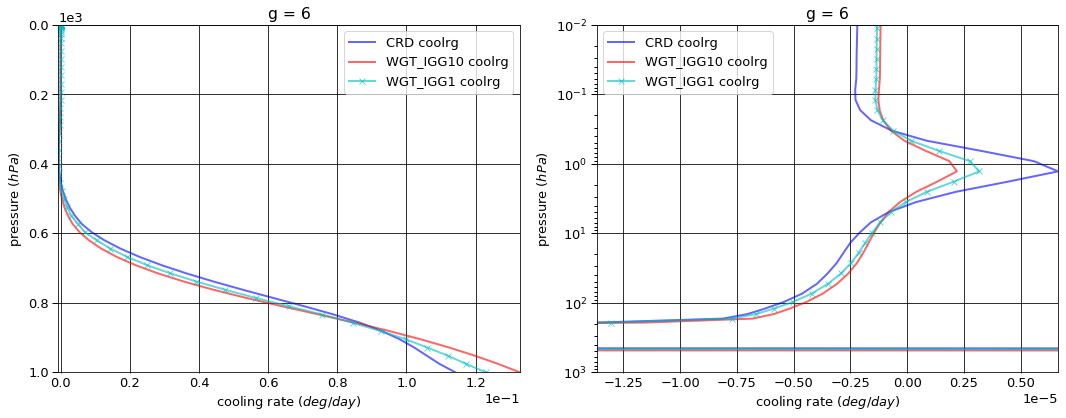

# Figure: cooling rate g-group 7

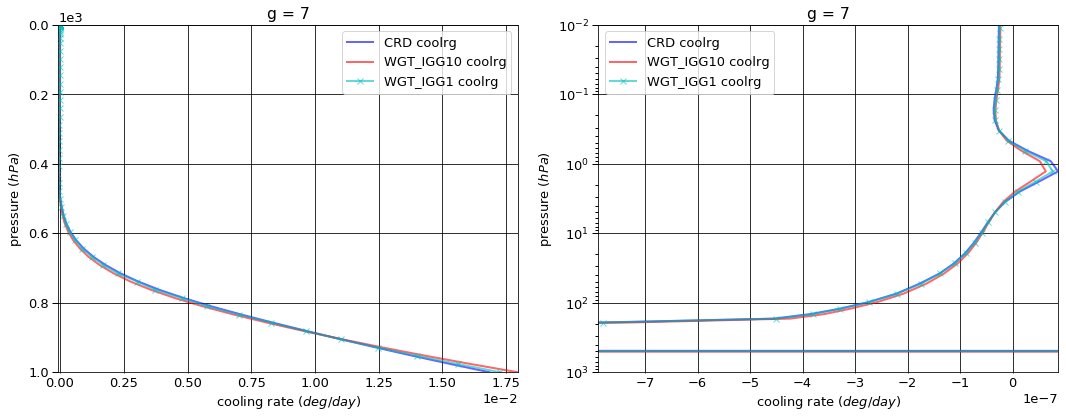

# Figure: cooling rate g-group total

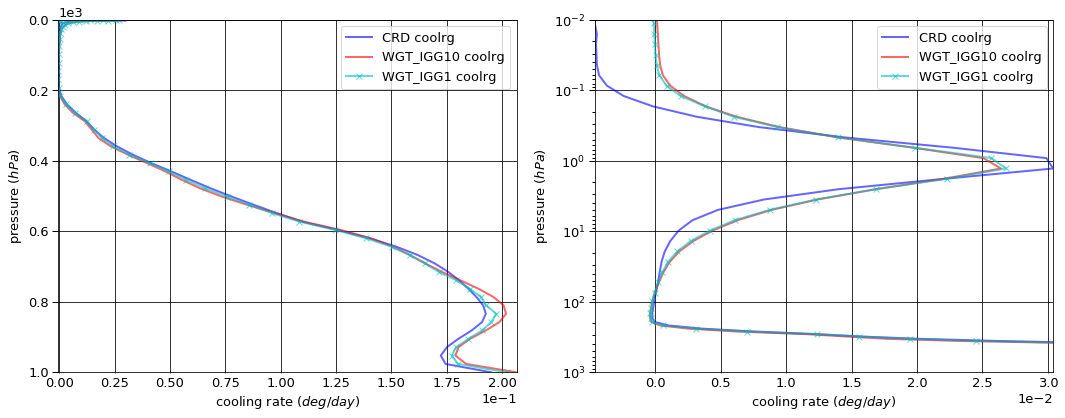

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024809  0.000000 -0.024809
  1013.0   76    -0.168537  0.168367 -0.000170
2 0.0      1     -0.130848  0.000000 -0.130848
  1013.0   76    -0.661844  0.661186 -0.000658
3 0.0      1     -0.549172  0.000000 -0.549172
  1013.0   76    -1.811400  1.809557 -0.001843
4 0.0      1     -2.223568  0.000000 -2.223568
  1013.0   76    -4.746419  4.719049 -0.027370
5 0.0      1     -4.733252  0.000000 -4.733252
  1013.0   76    -7.043324  6.679346 -0.363978
6 0.0      1     -6.315579  0.000000 -6.315579
  1013.0   76    -7.140427  4.078005 -3.062422
7 0.0      1     -2.120951  0.000000 -2.120951
  1013.0   76    -2.183224  0.399863 -1.783362


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024011  0.000000 -0.024011
  1013.0   76    -0.168537  0.168367 -0.000170
2 0.0      1     -0.124655  0.000000 -0.124655
  1013.0   76    -0.661844  0.661186 -0.000658
3 0.0      1     -0.534956  0.000000 -0.534956
  1013.0   76    -1.811400  1.809613 -0.001787
4 0.0      1     -2.203978  0.000000 -2.203978
  1013.0   76    -4.746419  4.725166 -0.021253
5 0.0      1     -4.774190  0.000000 -4.774190
  1013.0   76    -7.043324  6.827227 -0.216097
6 0.0      1     -6.434710  0.000000 -6.434710
  1013.0   76    -7.140427  3.920211 -3.220216
7 0.0      1     -2.124709  0.000000 -2.124709
  1013.0   76    -2.183225  0.394751 -1.788474


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024487  0.000000 -0.024487
  1013.0   76    -0.168537  0.168367 -0.000170
2 0.0      1     -0.124777  0.000000 -0.124777
  1013.0   76    -0.661844  0.661186 -0.000658
3 0.0      1     -0.535059  0.000000 -0.535059
  1013.0   76    -1.811400  1.809613 -0.001787
4 0.0      1     -2.199629  0.000000 -2.199629
  1013.0   76    -4.746419  4.721502 -0.024917
5 0.0      1     -4.755873  0.000000 -4.755873
  1013.0   76    -7.043324  6.778006 -0.265318
6 0.0      1     -6.381797  0.000000 -6.381797
  1013.0   76    -7.140427  3.952316 -3.188112
7 0.0      1     -2.122140  0.000000 -2.122140
  1013.0   76    -2.183225  0.398152 -1.785072


WGT_IGG10 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1      7.986280e-04  0.000000e+00  0.000799
  1013.0   76     0.000000e+00 -2.775558e-17  0.000000
2 0.0      1      6.193760e-03  0.000000e+00  0.006194
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
3 0.0      1      1.421613e-02  0.000000e+00  0.014216
  1013.0   76     0.000000e+00  5.660000e-05  0.000057
4 0.0      1      1.958990e-02  0.000000e+00  0.019590
  1013.0   76     0.000000e+00  6.117600e-03  0.006118
5 0.0      1     -4.093800e-02  0.000000e+00 -0.040938
  1013.0   76     0.000000e+00  1.478813e-01  0.147881
6 0.0      1     -1.191310e-01  0.000000e+00 -0.119131
  1013.0   76     0.000000e+00 -1.577946e-01 -0.157795
7 0.0      1     -3.758500e-03  0.000000e+00 -0.003759
  1013.0   76    -4.440892e-16 -5.111780e-03 -0.005112


WGT_IGG1 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1      3.226200e-04  0.000000e+00  0.000323
  1013.0   76     0.000000e+00 -2.775558e-17  0.000000
2 0.0      1      6.071440e-03  0.000000e+00  0.006071
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
3 0.0      1      1.411267e-02  0.000000e+00  0.014113
  1013.0   76     0.000000e+00  5.660000e-05  0.000057
4 0.0      1      2.393900e-02  0.000000e+00  0.023939
  1013.0   76     0.000000e+00  2.453000e-03  0.002453
5 0.0      1     -2.262120e-02  0.000000e+00 -0.022621
  1013.0   76     0.000000e+00  9.865990e-02  0.098660
6 0.0      1     -6.621810e-02  0.000000e+00 -0.066218
  1013.0   76     0.000000e+00 -1.256899e-01 -0.125690
7 0.0      1     -1.189100e-03  0.000000e+00 -0.001189
  1013.0   76    -4.440892e-16 -1.710460e-03 -0.001711

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.479039e-03
  1001.112500 75     6.068596e-05
2 0.000312    1      7.341927e-05
  1001.112500 75     2.353269e-04
3 0.000312    1     -1.387354e-04
  1001.112500 75     6.640938e-04
4 0.000312    1     -5.103110e-05
  1001.112500 75     9.364177e-03
5 0.000312    1     -1.876522e-05
  1001.112500 75     5.380331e-02
6 0.000312    1     -2.095266e-06
  1001.112500 75     1.141356e-01
7 0.000312    1     -2.334985e-08
  1001.112500 75     1.685274e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.692190e-05
  1001.112500 75     6.068596e-05
2 0.000312    1     -5.284951e-05
  1001.112500 75     2.353269e-04
3 0.000312    1     -4.537974e-05
  1001.112500 75     6.391396e-04
4 0.000312    1     -2.985782e-05
  1001.112500 75     8.134579e-03
5 0.000312    1     -1.060538e-05
  1001.112500 75     4.673229e-02
6 0.000312    1     -1.110214e-06
  1001.112500 75     1.328075e-01
7 0.000312    1     -2.080412e-08
  1001.112500 75     1.796225e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -2.849131e-04
  1001.112500 75     6.068596e-05
2 0.000312    1     -4.658637e-05
  1001.112500 75     2.353269e-04
3 0.000312    1     -4.635883e-05
  1001.112500 75     6.391396e-04
4 0.000312    1     -3.187749e-05
  1001.112500 75     9.323091e-03
5 0.000312    1     -1.160719e-05
  1001.112500 75     5.157956e-02
6 0.000312    1     -1.266884e-06
  1001.112500 75     1.229689e-01
7 0.000312    1     -2.215504e-08
  1001.112500 75     1.726613e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.452117e-03
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.262688e-04
  1001.112500 75     2.710505e-20
3 0.000312    1      9.335564e-05
  1001.112500 75    -2.495420e-05
4 0.000312    1      2.117327e-05
  1001.112500 75    -1.229598e-03
5 0.000312    1      8.159840e-06
  1001.112500 75    -7.071016e-03
6 0.000312    1      9.850527e-07
  1001.112500 75     1.867199e-02
7 0.000312    1      2.545728e-09
  1001.112500 75     1.109507e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.194125e-03
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.200056e-04
  1001.112500 75     2.710505e-20
3 0.000312    1      9.237655e-05
  1001.112500 75    -2.495420e-05
4 0.000312    1      1.915360e-05
  1001.112500 75    -4.108640e-05
5 0.000312    1      7.158036e-06
  1001.112500 75    -2.223748e-03
6 0.000312    1      8.283824e-07
  1001.112500 75     8.833330e-03
7 0.000312    1      1.194811e-09
  1001.112500 75     4.133900e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.098180,0.000000,-16.098180
1013.0,76,-23.755175,18.515373,-5.239802



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.221209,0.000000,-16.221209
1013.0,76,-23.755175,18.506522,-5.248653



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.143762,0.000000,-16.143762
1013.0,76,-23.755175,18.489142,-5.266033



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.123029,0.000000,-0.123029
1013.0,76,0.000000,-0.008851,-0.008851



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.045583,0.000000,-0.045583
1013.0,76,0.000000,-0.026231,-0.026231


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.004616
1001.112500,75,0.195116



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000167
1001.112500,75,0.206572



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000423
1001.112500,75,0.202073



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.004450
1001.112500,75,0.011456



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.004194
1001.112500,75,0.006957


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008424,0.006687
2,0.031636,0.026666
3,0.084424,0.073672
4,0.218545,0.193815
5,0.300909,0.294651
6,0.277394,0.308012
7,0.078667,0.096497


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.694881e-20
2,2.526252e-21
3,3.765425e-22
4,5.612436e-23
5,8.365440e-24
6,1.246884e-24
7,1.858504e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.694881e-20,NaN,0.008424,0.006687,0.008424,0.006687,600.0
2,2.526252e-21,0.149052,0.031636,0.026666,0.040061,0.033353,600.0
3,3.765425e-22,0.149052,0.084424,0.073672,0.124485,0.107025,600.0
4,5.612436e-23,0.149052,0.218545,0.193815,0.343030,0.300840,600.0
5,8.365440e-24,0.149052,0.300909,0.294651,0.643939,0.595491,600.0
6,1.246884e-24,0.149052,0.277394,0.308012,0.921333,0.903503,600.0
7,1.858504e-25,0.149052,0.078667,0.096497,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
